# Search based method for level generation

This project will explain how to use a search based method (specifically evolutionary search) to generate levels for a dungeon crawler. It will explain the core parts of the search based method along with how different content representations effect the outcome of the search.

This tutorial is based on the second chapter of the book: Procedural Content Generation in Games (https://www.pcgbook.com/chapter02.pdf)

## Key parts of the search based method:

The key components of the search based method are:
1. the algorithm
2. content representation
3. the evaluation function
4. the mutation function

## The algorithm

The algorithm is at the core (the book referes to it as the "engine") of the method. Its job is simple:
1. expand the next level of the search tree (partly) by mutating existing levels.
2. evaluate the new levels.
3. compare the new levels and the old ones together.
4. keep the best ones and discard the rest.
   
Let's take a look:

In [43]:
import math
import random
import heapq
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, update_display

In [57]:
LEVEL_SIZE = 50

def main(get_empty_level, mutate_level, evaluate, print_level):

    # Constants for exploration
    ITERATIONS = 30          # No. of iterations the algorithm will run for
    MUTATIONS_PER_LEVEL = 6  # How many new levels to generate for each existing level
    CONSIDERED_LEVELS = 10   # How many levels to keep at the end of an iteration
    
    # Create an array to store our levels and add the initial level
    curr_levels = [get_empty_level()]
    print_level(curr_levels[0])
    
    # The core of the algorithm
    for _ in range(ITERATIONS):
        score = []
        
        # Create new levels by from mutating existing ones
        for level in curr_levels:
            possibilities = [mutate_level(level) for _ in range(MUTATIONS_PER_LEVEL)]
            # Keep the level and its score
            score += [(evaluate(possibility), possibility) for possibility in possibilities]
        # Add the levels from the previous iteration
        score += [(evaluate(level), level) for level in curr_levels]
        # Shuffle the levels 
        random.shuffle(score)
        # Sort the levels by score, from highest to lowest
        score.sort(reverse=True, key=lambda x: x[0])
        # Discard weak levels
        curr_levels = [score_pair[1] for score_pair in score[:CONSIDERED_LEVELS]]

        print_level(curr_levels[0])

There are several parameters that can be tweaked here: the number of iterations, how many nodes of the next level to explore and how many nodes nodes to keep between iterations.

Here are a few things to take into consideration when changing the constants in the code:

 -  The larger the number of iterations, the more likely it is that you will find a good level, however this will increase the search time. Also, after a few iterations the algorithm might already have converged to a good enough solutions so having too many iterations may proove unnecessary.<br><br>
  
 - Inreasing the number of nodes between iterations will increase search time, since these nodes will need to be expanded in the future, however, not keeping enough nodes limits the amount of exploration the algorithm can do and it can converge to a less optimal solution<br><br>
 
 - Increasing the number of nodes to explore each iteration will increase search time, however the algorithm will also converge quicker.<br><br>
 
 - These parameters affect each other so keeping a good balance between them is crucial, however the only way to find this balance is through experimentation.

## Content representation

Content representation refers to how the level is encoded. Content can be represented on a scale from direct to indirect.
For example a direct representation would be a matrix where each element of the matrix represents the content of the level at that position (eg. is it a wall, door, empty space, ...) and an indirect representation would be storing a collection of rooms, each with its own positions and sizes.

There are many more possible representations, for example one can encode a level as the positions of manually created rooms (not random like the ones mentioned above) or as a random seed.

Here are two examples in code:

In [45]:
# Direct content representation:
# 2 dimensional level (50x50) where each element is in the range [0,6]

class Cells:
    EMPTY = 0
    WALL = 1
    DOOR = 2
    ENEMY = 3
    TREASURE = 4
    START = 5
    END = 6

def direct_get_empty_level():
    level = [ [0] * LEVEL_SIZE for _ in range(LEVEL_SIZE)]
    level[2][2] = Cells.START
    level[LEVEL_SIZE - 2][LEVEL_SIZE - 2] = Cells.END
    return level

In [46]:
# Indirect content representation:
# List of rooms

class Room:
    def __init__(self, x, y, width, height, enemies, treasures):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.enemies = []
        self.treasures = []
        
def indirect_get_empty_level():
    return []

Usually the more direct the representation the larger the search space, but it can result in more creative levels that are not confined by the assumptions made by the more indirect representations.

#### Make sure you only run one of these two blocks.

## Evaluation function

The evaluation function takes an instance of a level and returns parameters that are used to compare level instances between them. Some examples of characteristics that could be considered would be: difficulty( which could be measured as no. of enemies per room) or explorability (which could be measured as no. of rooms).

The evaluation function is tied to the content representation, since if the level is represented in a different format, the evaluation function won't know how to interpret it.

For the direct content representation, an ideal number of walls, enemies and treasures has been defined. The number of enemies will dictate how difficult the level will be whereas the number of treasures can incentivise exploration. Another factor that will be measured will be the distance from the start to the end. The larger the distance the more the player will have to explore and if the distance is infinite, then it is impossible to finish the level so it should score lower.

A couple helper functions have been defined: the first one is used to get valid neighbouring cells and the second one is the A* algorithm. These function will not be explained as they are outside the scope of this tutorial.

In [47]:
def get_neighbours(cell):
    """
        Returns the cells the player can legally move to from the given position
    """
    DIRECTIONS = [(1,0), (-1,0), (0,1), (0,-1)]
    retval = []
    for direction in DIRECTIONS:
        next_cell = (cell[0] + direction[0], cell[1] + direction[1])

        if next_cell[0] < 0 or next_cell[0] >= LEVEL_SIZE:
            continue
        if next_cell[1] < 0 or next_cell[1] >= LEVEL_SIZE:
            continue
            
        retval.append(next_cell)
    return retval

In [48]:
def astar(level, start, destination):
    """
        Returns the path from the start cell to the destination cell if it exists
        Uses the A* algorithm
    """

    # Since the player can only move in 4 directions, the Manhattan distance is enough
    # instead of the Euclidian cheaper.
    def heuristic(start, destination):
        return abs(start[0] - destination[0]) + abs(start[1] - destination[1])

    # Holds the cells where we came from.
    previous_cells = {}

    # Holds cells we have already visited
    visited = set()

    # Holds cells we need to visit (f(node) - estimated distance, g(node) - distance so far, prev_node - position we came from, node - current position)
    queue = []
    heapq.heappush(queue, (0, 0, start, start))

    while queue:
        estimated_distance, distance_travelled, previous_cell, cell = heapq.heappop(queue)

        previous_cells[cell] = previous_cell

        if cell in visited:
            continue

        if cell == destination:
            break

        visited.add(cell)

        neighbours = get_neighbours(cell)
        for next_cell in neighbours:
            if next_cell in visited:
                continue
            
            if level[next_cell[1]][next_cell[0]] in [Cells.WALL, Cells.TREASURE, Cells.DOOR]:
                continue
                
            heapq.heappush(queue, (heuristic(next_cell, destination) + distance_travelled + 1, distance_travelled + 1, cell, next_cell))

    if destination not in previous_cells:
        return []

    # Construct path from start to destination

    path = []
    curr_pos = destination
    while curr_pos != start:
        path.append(curr_pos)
        curr_pos = previous_cells[curr_pos]
    
    return path

Here is the code for the evaluation function for the direct representation:

In [49]:
def direct_evaluate(level):
    
    # We don't want to create too many walls as this will make some areas inaccesible and it also looks ugly
    IDEAL_WALL_COUNT = 600
    # How many treasures do we want per level (on average)
    IDEAL_TREASURE_COUNT = 5
    # How many enemies do we want per level (on average)
    IDEAL_ENEMY_COUNT = 10

    start_pos = None
    end_pos = None
    enemies = []
    treasures = []
    wall_count = 0

    # Go through each cell in the level and count how many instances of each cell type do we have
    for y in range(len(level)):
        for x in range(len(level[y])):
            
            if level[y][x] == Cells.ENEMY:
                    enemies.append((x,y))
            elif level[y][x] == Cells.TREASURE:
                    treasures.append((x,y))
            elif level[y][x] == Cells.START:
                    start_pos = (x,y)
            elif level[y][x] == Cells.END:
                    end_pos = (x,y)
            elif level[y][x] == Cells.WALL:
                    wall_count += 1
    
    # Find the path to the exit
    path_to_victory = astar(level, start_pos, end_pos)

    # Calculate our hieuristic
    return len(path_to_victory) - \
            abs(IDEAL_WALL_COUNT - wall_count) - \
            abs((IDEAL_ENEMY_COUNT - len(enemies)) ** 2) - \
            abs((IDEAL_TREASURE_COUNT - len(treasures)) ** 2)

Some things to note:
 - We have set a limit on how many walls we want per level. This is to stop the algorithm from filling up the entire level, making some treasures and enemies inaccesible and greatly reducing explorability.<br><br>
 - The constants above have been found through experimentation<br><br>
 - The difference in the enemies and treasures has been raised to the power of two. This is to stop the algorithm from generating too many enemies but compensating for it by generating fewer treasures. Also it is acceptable to have one extra or fewer enemy, but if the algorithm tries to deviate too much from the ideal we want to punish it harder.<br><br>
 - The number of walls has NOT been raised to the power of two. This is because we can be more leniant on how many walls are generated and it will not interfere with the other two metrics since both have been raised to the power of two.

For the indirect representation, we have set the number of rooms we want and the density of enemies and treasures we want per level.

In [50]:
# https://www.jeffreythompson.org/collision-detection/rect-rect.php
def are_rooms_colliding(room1, room2):
    if room1.x <= room2.x + room2.width and \
        room1.x + room1.width >= room2.x and \
        room1.y <= room2.y + room2.height and \
        room1.y + room1.height >= room2.y:

        return True
    return False

def density_error_function(ideal, actual):
        return 3*(math.exp(abs(ideal - actual)*10)-1)

def indirect_evaluate(level):

    if len(level) == 0:
        return 0

    IDEAL_NO_OF_ROOMS = 9999    # Create as many rooms as you can
    IDEAL_ENEMY_DENSITY = 1/(5*5)       # What fraction of the room should be enemies (2 enemies in a 5x5 room on average)
    IDEAL_TREASURE_DENSITY = 0.5/(5*5)  # What fraction of the room should be covered in treasure chests (one treasure in every second 5x5 room)

    # Rooms that are overlapping will be discarded
    no_of_rooms = len(level)
    enemy_density = 0
    treasure_density = 0

    # TODO: what about one room colliding with multiple
    for room_index, room in enumerate(level):

        for other_room in level[(room_index+1):]:
            if are_rooms_colliding(room, other_room):
                no_of_rooms -= 2
                break
        
        # TODO: this does not take into consideration overlapping rooms
        enemy_density += density_error_function(IDEAL_ENEMY_DENSITY, len(room.enemies) / (room.width * room.height))
        treasure_density += density_error_function(IDEAL_TREASURE_DENSITY, len(room.treasures) / (room.width * room.height))

    room_count_error = abs(IDEAL_NO_OF_ROOMS - max(no_of_rooms, 0)*4)

    return 9999 - room_count_error - enemy_density / len(level) - treasure_density / len(level)

The function called "density error function" is used to calculate the error for the two dnsities. We calculate the absolute value of the difference and we pass it through an exponential function. This is to punish the algorithm harder for deviating too much from the ideal densities. The constants the expression is being multiplied by were found through experimentation and are used to punish the algorithm more.

We also punish the algorithm for placing rooms on top of each other. Instead of just punishing the algorithm for stacking levels, one could try to merge these rooms to create more interesting shapes, however this is left as an optional exercise to the reader.

#### Make sure you only run the block for one of the evaluation functions.

## Mutation function

The mutation function is responsible for creating variations in the levels. It is important that these variations are not too dramatic and that a mutation does not change its evaluation too much as this can effect the search algorithms ability to find a solution at all.

### Direct Representation
To mutate a level the book suggests creating a random 50x50 matrix, with each element taken from the N(0,1) distribution, however I chose to use a different approach, for more fine-grained control. Originally, this was intended to guide the mutation function to create structures that look like rooms, however this seemed to not work, instead it is now used to create layouts that seem like cave.

There is a certain (predefined) probability, that a cell turns into a different one, just like in the book, however, the most notable difference is that these probabilities do not have to be the same and they can be adjusted, and that it is more likely that the mutation places a wall next to another wall, creating clusters and a more natural cave. 

In [51]:
def direct_mutate_level(level):
    new_level = [ [0] * LEVEL_SIZE for _ in range(LEVEL_SIZE)]

    PROBABILITY = {
        "empty_to_wall_no_neighbour": 0.001,
        "empty_to_wall_with_neighbour": 0.1,
        "empty_to_treasure": 0.0005,
        "empty_to_enemy": 0.0005,
        "wall_to_empty": 0.0005,
        "enemy_to_empty": 0.0005,
        "treasure_to_empty": 0.0005
    }
    
    for y in range(len(level)):
        for x in range(len(level[y])):
            cell = level[y][x]

            new_level[y][x] = cell
            
            if cell == Cells.EMPTY:
                wall_neighbour_count = 0

                for neighbour in get_neighbours((x,y)):
                    if level[neighbour[1]][neighbour[0]] == Cells.WALL:
                        wall_neighbour_count += 1

                if wall_neighbour_count == 0:
                    if random.random() < PROBABILITY["empty_to_wall_no_neighbour"]:
                        new_level[y][x] = Cells.WALL
                else:
                    if random.random() < PROBABILITY["empty_to_wall_with_neighbour"]:
                        new_level[y][x] = Cells.WALL
                
                # If the empty space has not turned into a wall,
                # try turning it into treasure or an enemy
                if new_level[y][x] == Cells.EMPTY:
                    if random.random() < PROBABILITY["empty_to_treasure"]:
                        new_level[y][x] = Cells.TREASURE
                    
                    elif random.random() < PROBABILITY["empty_to_enemy"]:
                        new_level[y][x] = Cells.ENEMY

            
            if cell == Cells.WALL:
                if random.random() < PROBABILITY["wall_to_empty"]:
                    new_level[y][x] = Cells.EMPTY
            
            if cell == Cells.ENEMY:
                if random.random() < PROBABILITY["enemy_to_empty"]:
                    new_level[y][x] = Cells.EMPTY
            
            if cell == Cells.TREASURE:
                if random.random() < PROBABILITY["treasure_to_empty"]:
                    new_level[y][x] = Cells.EMPTY

    return new_level

This function simply adds or subtracts 1 from the position and dimensions of existing rooms randomly, and sometimes completely deletes or generates new rooms.

The biggest headache with this mutation function was keeping the room in the map. All the min and max function make the code less readable, however they are essential in keeping the rooms inside the map.

In [52]:
def is_point_in_room(point, room):
    if room.x < point[0] and \
        point[0] < room.x + room.width and \
        room.y < point[1] and \
        point[1] < room.y + room.height:

        return True
    
    return False

def add_entity(room, array):
    if random.random() < 0.5:
        tries = 0
        entity = (random.randrange(room.x + 1, room.x + room.width), random.randrange(room.y + 1, room.y + room.height))
        while (entity in room.enemies or entity in room.treasures) and tries < 10:
            entity = (random.randrange(room.x + 1, room.x + room.width), random.randrange(room.y + 1, room.y + room.height))
            tries += 1
        if tries < 10:
            array.append(entity)
    elif array and random.random() < 0.5:
        del array[random.randrange(len(array))]

def indirect_mutate_level(level):
    new_level = []
    for room in level:
        # Random chance to delete this level
        if random.random() < 0.05:
            continue

        room.x = min(max(0, room.x + random.randint(-1,1)), LEVEL_SIZE - room.width - 1)
        room.y = min(max(0, room.y + random.randint(-1,1)), LEVEL_SIZE - room.height - 1)
        room.width = max(min(room.width + random.randint(-1,1), LEVEL_SIZE - room.x - 1), 5)
        room.height = max(min(room.height + random.randint(-1,1), LEVEL_SIZE - room.y - 1), 5)

        # Make sure a mutation of the room did not leave us with a treasure or enemy outside of it
        # If it did, remove them
        enemies = []
        treasures = []
        for enemy in room.enemies:
            if is_point_in_room(enemy, room):
                enemies.append(enemy)
        
        for treasure in room.treasures:
            if is_point_in_room(treasure, room):
                treasures.append(treasure)

        room.enemies = enemies
        room.treasures = treasures

        # Randomly add or remove an enemy
        add_entity(room, room.enemies)

        # Randomly add or remove a treasure
        add_entity(room, room.treasures)

        new_level.append(room)
    
    # Random chance to add new levels
    if random.random() < 0.1:
        width = random.randint(4,10)
        height = random.randint(4,10)

        room = Room(
            random.randint(0,40),     # x
            random.randint(0,40),     # y
            width,                    # width
            height,                   # height
            [],                       # enemies
            []                        # treasures
        )

        enemies = []
        treasures = []

        for _ in range(random.randrange(int(width * height / 8))):
            add_entity(room, enemies)
            room.enemies = enemies
        
        for _ in range(random.randrange(int(width * height / 8))):
            add_entity(room, treasures)
            room.treasures = treasures
        
        room.enemies = enemies
        room.treasures = treasures

        new_level.append(room)
    
    return new_level

## The result

One last thing that we need to do before we can run our program is to set up a function that displays us the levels. Notice how for the direct representation, we just map the cell types to a color (could be a sprite from a spritesheet in a real game), however displaying a level encoded with the indirect representation is significantly harder.

In [53]:
CELL_REPRESENTATION = np.asarray([
    (240, 240, 240),
    (10, 10, 10),
    (0, 0, 0),
    (125, 63, 8),
    (175, 21, 21),
    (231, 218, 34),
    (130, 34, 231),
    (34, 231, 51)
])

labels =[
    mpatches.Patch(color='black', label='Wall'),
    mpatches.Patch(color='white', label='Empty'),
    mpatches.Patch(color='yellow', label='Start'),
    mpatches.Patch(color='purple', label='End'),
    mpatches.Patch(color='red', label='Enemy'),
    mpatches.Patch(color='brown', label='Treasure'),
]

In [54]:
def direct_print_level(level):
    img = CELL_REPRESENTATION[np.asarray(level)]
    im = plt.imshow(img)
    red_patch = mpatches.Patch(color='red', label='The red data')
    plt.legend(handles=labels, bbox_to_anchor=(1.4, 1))
    
    update_display(im.figure, display_id=1)

In [55]:
def is_room_margin(point, room):
    return (point[0] == room.x and point[1] >= room.y and point[1] <= room.y + room.height) or \
        (point[0] == room.x + room.width and point[1] >= room.y and point[1] <= room.y + room.height) or \
        (point[1] == room.y and point[0] >= room.x and point[0] <= room.x + room.width) or \
        (point[1] == room.y + room.height and point[0] >= room.x and point[0] <= room.x + room.width)

def indirect_print_level(level):
    
    img = np.full((LEVEL_SIZE, LEVEL_SIZE, 3), 240, dtype=int)
    
    enemies = []
    treasures = []

    for room in level:
        enemies += room.enemies
        treasures += room.treasures
    
    for y in range(LEVEL_SIZE):
        for x in range(LEVEL_SIZE):
            if (x,y) in enemies:
                img[x,y,:] = CELL_REPRESENTATION[3]
                continue
            
            if (x,y) in treasures:
                img[x,y,:] = CELL_REPRESENTATION[4]
                continue
            
            is_wall = False
            for room1 in level:
                if (x == room1.x and y >= room1.y and y <= room1.y + room1.height) or \
                    (x == room1.x + room1.width and y >= room1.y and y <= room1.y + room1.height) or \
                    (y == room1.y and x >= room1.x and x <= room1.x + room1.width) or \
                    (y == room1.y + room1.height and x >= room1.x and x <= room1.x + room1.width):


                    is_wall = True
                    for room2 in level:
                        if is_point_in_room((x,y), room2):
                            is_wall = False
                            break

                    if not is_wall:
                        break

            if is_wall:
                img[x,y,:] = CELL_REPRESENTATION[1]
                continue
    im = plt.imshow(img)
    red_patch = mpatches.Patch(color='red', label='The red data')
    plt.legend(handles=labels, bbox_to_anchor=(1.4, 1))
    update_display(im.figure, display_id=1)

Set RUN_DIRECT to true to use the direct representation or to false to use the indirect representation.

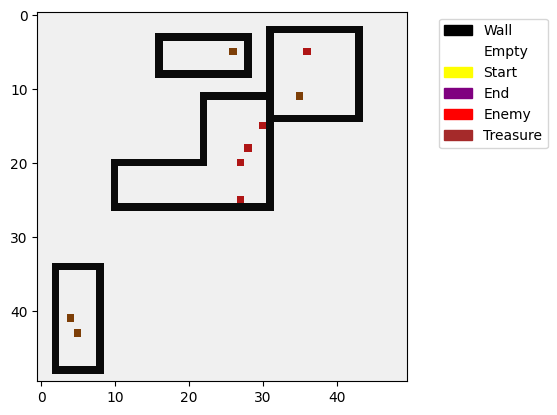

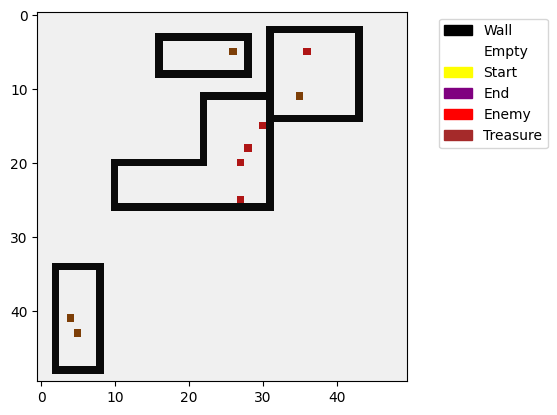

In [60]:
RUN_DIRECT = False

display([], display_id=1)
if RUN_DIRECT:
    main(direct_get_empty_level, direct_mutate_level, direct_evaluate, direct_print_level)
else:
    main(indirect_get_empty_level, indirect_mutate_level, indirect_evaluate, indirect_print_level)

The first thing to notice is how different the levels are. The levels generated by the indirect representations are what you would traditionally find in a dungeon crawler, however the ones generated by the direct representation look more like caves and have a more organic feel to them. Also notice the time it took to generate the levels: the direct representation was MUCH slower than the indirect one. We have deviated from the mutation function used in the book, however even if we were to use the same one, the indirect representation would still be faster since the search space is significantly smaller.